In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import scipy.interpolate
from scipy.ndimage import gaussian_filter
import tifffile
import seaborn as sns

from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.notebook import tqdm, trange
from scipy.optimize import curve_fit
#import gaussian
from skimage.filters import gaussian
from scipy.interpolate import RectBivariateSpline
from PIL import Image
import itertools
from scipy.ndimage import binary_dilation

## PATHS and CONSTANTS



In [2]:
PROJECT_PATH = 'C:/Users/amityu/DataspellProjects/gel_sheets/'
DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
#movie = 'Control'
#movie = '130721'
#movie ='140721'
#movie ='150721'
#movie ='100621'
movie ='130721_CCA60_RAW'
#movie ='280523 AM100 568'
ADD_PATH = os.path.join(PROJECT_PATH, "add_data/", movie + "/")


MOVIE_PATH = DATA_PATH +  movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'

In [3]:
spike = np.load(MOVIE_PATH + 'np/spike.npy').astype(np.float32)

In [5]:
from scipy.interpolate import Rbf
import scipy.optimize
#import gaussian_filter
from scipy.ndimage import gaussian_filter
# Define 2D polynomial function
def poly_2d(xy, *coeffs):
    x, y = xy
   
    degree = int(np.sqrt(len(coeffs))) - 1
    z = np.zeros_like(x, dtype=np.float32)
    k = 0
    for i in range(degree + 1):
        for j in range(degree + 1):
            z += coeffs[k] * x**i * y**j
            k += 1
    return z



# Generate example data
np.random.seed(0)  # for reproducibility
x = np.arange(0,spike.shape[2])
y = np.arange(0,spike.shape[1])
x, y = np.meshgrid(x, y)

t = 10
z = spike[t]
nan_mask = np.isnan(z)
x=x[~nan_mask].flatten()
y=y[~nan_mask].flatten()
z=z[~nan_mask].flatten()

#z = gaussian_filter(spike[t][x,y], 5)  # Some example data with noise

# Apply Rbf interpolation
#rbf = Rbf(x[not_nan_mask], y[not_nan_mask], z[not_nan_mask], function='linear')
#z_interpolated = rbf(x, y)
#z_flat = z_interpolated.flatten()
# Replace NaN values in z with interpolated values

degree = 50  # Choose your degree
initial_guess = np.ones((degree + 1) * (degree + 1))  # Initial guess for coefficients
params, _ = scipy.optimize.curve_fit(poly_2d, (x, y), z, p0=initial_guess)

# Now params contains the coefficients of the 2D polynomial


C:\Users\amityu\AppData\Local\Temp\ipykernel_19232\534291594.py:14: RuntimeWarning: overflow encountered in add
  z += coeffs[k] * x**i * y**j


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
x = np.arange(0,spike.shape[2])
y = np.arange(0,spike.shape[1])
z = spike[t]
x, y = np.meshgrid(x, y)
x=x.flatten()
y=y.flatten()
z_fit = poly_2d((x, y), *params)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Display original data
im0 = ax[0].imshow(z, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()))
ax[0].set_title('Original Data')
divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im0, cax=cax0)

# Display fitted data
im1 = ax[1].imshow(z_fit, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()))
ax[1].set_title('Fitted Data')
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax1)

plt.tight_layout()
plt.show()

In [31]:
import numpy as np
import scipy.io

# Create a NumPy array


# Save it to a .mat file
scipy.io.savemat(MOVIE_PATH + 'tmp/spike.mat', {'my_array': spike})


#<span style="color:red">CUrvature with soble filter</span>

In [94]:
from skimage.filters import sobel_h, sobel_v
def gaussian_curvature(surface):
    nan_mask = np.isnan(surface)
    dilated_nan_mask = binary_dilation(nan_mask)
    # Compute the partial derivatives of the surface using convolution
    dx = sobel_h(surface)
    dy = sobel_v(surface)
    dxx = sobel_h(dx)
    dyy = sobel_v(dy)
    dxy = sobel_v(dx)
    # Compute the curvature
    curvature = (dxx * dyy - dxy**2) / (1 + dx**2 + dy**2)**2
    curvature[dilated_nan_mask] = np.nan
    return curvature

In [82]:
t = 32
sigma = 1.5


z = gaussian_filter(spike[t], sigma)  # Some example data with noise
curvature = gaussian_curvature(z)


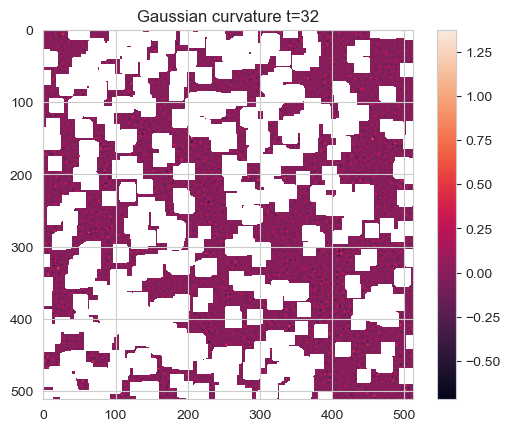

In [83]:
import matplotlib.pyplot as plt
plt.imshow(curvature)

plt.colorbar()
plt.title('Gaussian curvature t=%d' % t)
plt.show()


In [ ]:
#make animation of curtvature of spike each frame is a time point

KeyboardInterrupt: 

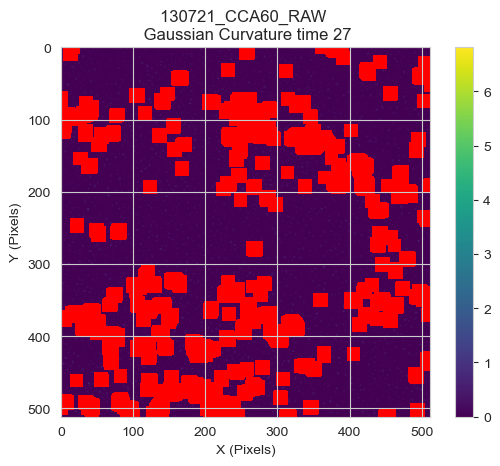

In [81]:

curvature = np.zeros_like(spike)
sigma = 1.5
for t,img in enumerate(spike):
    z = gaussian_filter(img, sigma)  # Some example data with noise
    curvature[t] = gaussian_curvature(z)

fig = plt.figure()
ax = fig.add_subplot(111)
# Create an empty plot
plot = ax.imshow(curvature[0], cmap = cmap,vmin=np.nanmean(curvature), vmax = np.nanmax(curvature) ,animated=True)

cmap = plt.cm.viridis  # Choose the colormap you prefer
cmap.set_bad(color='red')
cbar = plt.colorbar(plot)

plt.xlabel('X (Pixels)')
plt.ylabel('Y (Pixels)')

def update_frame(t):
    ax.imshow(curvature[t],vmin=np.nanmean(curvature), vmax = np.nanmax(curvature), cmap=cmap)

    #ax.set_title('movie %s Frame: %d \n Intesity projection \n i =  %d -  %d' % (movie,t,i,i+i_gap))
    ax.set_title('%s \n Gaussian Curvature time %d' % (movie,t    ))
    # Highlight the specified coordinates
    #plot.axes.plot(x_coord, y_coord, 'ro')

    return plot,

# Create the animation
myanimation = animation.FuncAnimation(fig, update_frame, frames=range(len(spike)), interval=1000, blit=True)
writer = animation.FFMpegWriter(fps=1)

myanimation.save(GRAPH_PATH + 'curvature/' + movie + 'Gaussian Curvature.mp4', writer=writer)

In [95]:

curvature = np.zeros_like(spike)
sigma = 5
for t,img in enumerate(spike):
    z = gaussian_filter(img, sigma)  # Some example data with noise
    curvature[t] = gaussian_curvature(z)


C:\Users\amityu\AppData\Local\Temp\ipykernel_9440\1799468590.py:1: RuntimeWarning: Mean of empty slice
  mean_curvature = np.nanmean(curvature, axis = (1,2))


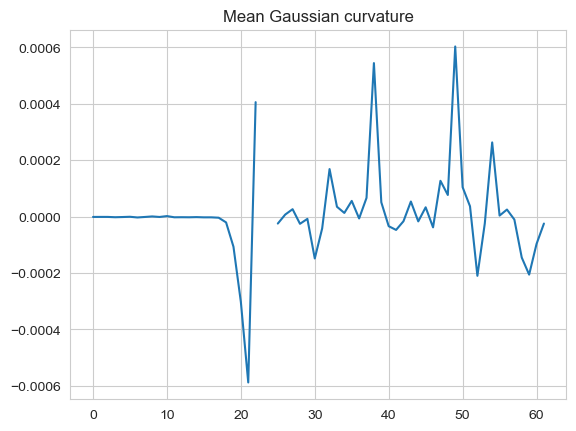

In [89]:
mean_curvature = np.nanmean(curvature, axis = (1,2))
plt.plot(mean_curvature)
plt.title('Mean Gaussian curvature')
plt.show()


In [97]:
import numpy as np
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import LinearColorMapper, Slider
from bokeh.layouts import column
from bokeh.palettes import Viridis256
from bokeh.transform import transform
from bokeh.models.sources import ColumnDataSource
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

output_notebook()

def modify_doc(doc):
    # Example 3D data
    data_3d = curvature  # Replace this with your 3D array

    # Create ColumnDataSource
    source = ColumnDataSource(data={'image': [data_3d[0,:, :]]})

    # Set up plot
    p = figure(width=500, height=500, x_range=(0, 10), y_range=(0, 10), title="Animated 3D Array")
    p.image(image='image', x=0, y=0, dw=10, dh=10, source=source, color_mapper=LinearColorMapper(palette=Viridis256))

    # Set up slider
    slider = Slider(start=0, end=data_3d.shape[2]-1, value=0, step=1, title="Index")

    # Update function
    def update(attr, old, new):
        source.data = {'image': [data_3d[slider.value,:, :]]}

    slider.on_change('value', update)

    # Organize layout
    layout = column(p, slider)

    # Add to doc
    doc.add_root(layout)

handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)


Loading BokehJS ...

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p1322'}, 'attr': 'value', 'new': 67}]} 
 error: IndexError('index 67 is out of bounds for axis 0 with size 62')
Traceback (most recent call last):
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 97, in handle
    work = await handler(message, connection)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\server\session.py", line 94, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\server\session.py", line 286, in _handle_patch
    message.apply_to_document(self.document, self)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 104, in apply_to_document
    invoke_with_curdoc(doc, lambda: doc.apply_json_patc

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p1322'}, 'attr': 'value', 'new': 84}]} 
 error: IndexError('index 84 is out of bounds for axis 0 with size 62')
Traceback (most recent call last):
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 97, in handle
    work = await handler(message, connection)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\server\session.py", line 94, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\server\session.py", line 286, in _handle_patch
    message.apply_to_document(self.document, self)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 104, in apply_to_document
    invoke_with_curdoc(doc, lambda: doc.apply_json_patc

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p1322'}, 'attr': 'value', 'new': 101}]} 
 error: IndexError('index 101 is out of bounds for axis 0 with size 62')
Traceback (most recent call last):
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 97, in handle
    work = await handler(message, connection)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\server\session.py", line 94, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\server\session.py", line 286, in _handle_patch
    message.apply_to_document(self.document, self)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 104, in apply_to_document
    invoke_with_curdoc(doc, lambda: doc.apply_json_pa

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p1322'}, 'attr': 'value', 'new': 118}]} 
 error: IndexError('index 118 is out of bounds for axis 0 with size 62')
Traceback (most recent call last):
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 97, in handle
    work = await handler(message, connection)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\server\session.py", line 94, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\server\session.py", line 286, in _handle_patch
    message.apply_to_document(self.document, self)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 104, in apply_to_document
    invoke_with_curdoc(doc, lambda: doc.apply_json_pa